In [13]:
import json
import pandas as pd
from pathlib2 import Path
import sys
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class Experiment(object):
  def __init__(self, path, output_checker):
    self.expr_path = Path(path).resolve()
    self.expr_name = self.expr_path.stem
    self.expr_json = self.expr_path.joinpath(self.expr_name + '_faults.json')
    self.expr_check = output_checker
    
    assert self.expr_json.exists(), \
          "File {name} not exists".format(name=self.expr_json)
    
    self.Records = pd.DataFrame()
    self.load()
   
  def load(self):
    func = dict()     # the function where the injection is performed
    orig = dict()     # the original value of the target state
    wrng = dict()     # the faulty value after injection
    flip = dict()     # the bit flipped
    stat = dict()     # the status of the target execution
    spac = dict()     # the space, application space or library space
    libs = dict()     # the library where the failure is manifested
    regs = dict()
    loc = dict()
    
    DF = pd.DataFrame()
   
    with open(self.expr_json, 'r') as fh:
      faults = fh.readlines()
      
    runs = len(faults)
    
    for item in faults:
      try:
        record = json.loads(item)
      except:
        print(item)
        print(item[370:380])
        sys.exit()
      
      iid = record['id']    # injection id
      func[iid] = record['fault']['parent_func']
      orig[iid] = record['fault']['normal_value']
      wrng[iid] = record['fault']['faulty_value']
      flip[iid] = record['fault']['bit_flipped']
      regs[iid] = record['fault']['location']['location']['base']
      loc[iid] = record['fault']['location']['type']
      if record['fault']['library'] == None:
        spac[iid] = "App"
        libs[iid] = "None"
      else:
        spac[iid] = "lib"
        libs[iid] = record['fault']['library'] 
      stat[iid] = record['status']
      
    DF = pd.concat([DF, pd.Series(regs, name='regs')], axis=1, sort=True)
    DF = pd.concat([DF, pd.Series(stat, name='stat')], axis=1, sort=True)
    DF = pd.concat([DF, pd.Series(flip, name='bit')], axis=1, sort=True)
    DF = pd.concat([DF, pd.Series(loc, name='loc')], axis=1, sort=True)
    
    self.Records = DF  
    
  def get_loc_dist(self):
    return self.Records['loc'].value_counts()

  def get_target_dist(self):
    mem = self.Records[self.Records['loc'] == 'mem']['loc'].count()
    reg = self.Records[self.Records['loc'] == 'reg']['regs'].value_counts()
    reg['mem'] = mem
    return reg

  def get_normal_executions(self):
    DF = self.Records
    profile = self.expr_path.joinpath('profile/stdout')
    
    Normal = DF.loc[DF['stat'] == 'Normal']
    ids = list(Normal.index)
    res = list()
    for i in ids:
        run = self.expr_path.joinpath(i).joinpath('stdout')
        try:
            status = self.expr_check(profile, run)
        except:
            status = 'Hang'
            print(i, '---> Profile: ', profile, '---> Run: ', run)
        if status is 'Normal':
            res.append(i)
            
    return res


In [3]:
# GTC-P
def gtcp_output_checker(profile, run):
  with open(profile) as fh:
    line = fh.readlines()[-21].split(' ')
    profile_efield = float(line[1].strip(',').split('=')[1])
    profile_eradial= float(line[2].strip(',').split('=')[1])
    profile_entropyi = float(line[3].strip(',').split('=')[1])
    profile_dflowi = float(line[4].strip(',').split('=')[1])
    profile_pfluxi = float(line[5].strip(',').split('=')[1])
    profile_efluxi = float(line[6].strip(',').split('=')[1])
    profile_weights = float(line[11].strip(',').split('=')[1])

  with open(run) as fh:
    line = fh.readlines()[-21].split(' ')
    run_efield = float(line[1].strip(',').split('=')[1])
    run_eradial= float(line[2].strip(',').split('=')[1])
    run_entropyi = float(line[3].strip(',').split('=')[1])
    run_dflowi = float(line[4].strip(',').split('=')[1])
    run_pfluxi = float(line[5].strip(',').split('=')[1])
    run_efluxi = float(line[6].strip(',').split('=')[1])
  
  efield_diff = abs(run_efield - profile_efield)
  eradial_diff = abs(run_eradial - profile_eradial)
  entropyi_diff = abs(run_entropyi - profile_entropyi)
  dflowi_diff = abs(run_dflowi - profile_dflowi)
  pfluxi_diff = abs(run_pfluxi - profile_pfluxi)
  efluxi_diff = abs(run_efluxi - profile_efluxi)
  
  if efield_diff != 0.0 or eradial_diff != 0.0 or entropyi_diff != 0.0:
    return 'SDC'
  if pfluxi_diff != 0.0 or efluxi_diff != 0.0 :
    return 'SDC'
  return "Normal"

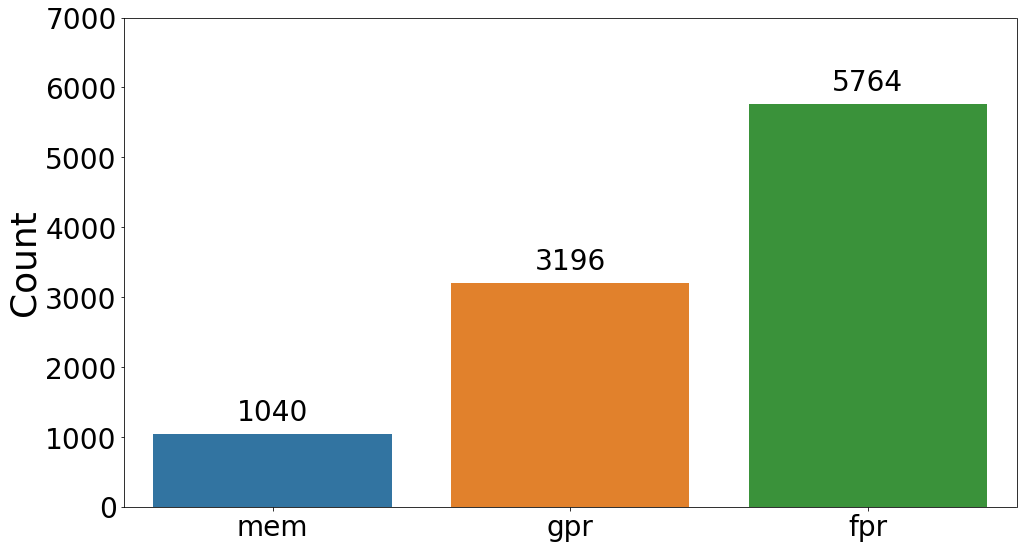

In [15]:
expr = Experiment('/home/cchen/Documents/Projects/CARE/Benchmarks/GTCP/GTCP_Dec_30', gtcp_output_checker)
loc = expr.get_target_dist()
gpr = 0
fpr = 0
for i in loc.index:
    if i == 'mem': 
        continue
    elif i.startswith('xmm'):
        fpr = fpr + loc[i]
    else:
        gpr = gpr + loc[i]
        
target = pd.DataFrame({'type': ['mem', 'gpr', 'fpr'], 'Value': [loc['mem'], gpr, fpr]})
ax = sns.barplot(x='type', y='Value', data=target)
ax.set_ylim([0,7000])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+200,
            '{:1.0f}'.format(height),
            ha="center", fontsize=28) 
    
plt.gcf().set_size_inches(16, 9)
ax.set_ylabel("Count", fontsize=36)
ax.set_xlabel("", fontsize=36)
ax.tick_params(labelsize=28)

In [16]:
ids = expr.get_normal_executions()

inject-0943 ---> Profile:  /home/cchen/Documents/Projects/CARE/Benchmarks/GTCP/GTCP_Dec_30/profile/stdout ---> Run:  /home/cchen/Documents/Projects/CARE/Benchmarks/GTCP/GTCP_Dec_30/inject-0943/stdout
inject-1386 ---> Profile:  /home/cchen/Documents/Projects/CARE/Benchmarks/GTCP/GTCP_Dec_30/profile/stdout ---> Run:  /home/cchen/Documents/Projects/CARE/Benchmarks/GTCP/GTCP_Dec_30/inject-1386/stdout
inject-3749 ---> Profile:  /home/cchen/Documents/Projects/CARE/Benchmarks/GTCP/GTCP_Dec_30/profile/stdout ---> Run:  /home/cchen/Documents/Projects/CARE/Benchmarks/GTCP/GTCP_Dec_30/inject-3749/stdout
inject-6905 ---> Profile:  /home/cchen/Documents/Projects/CARE/Benchmarks/GTCP/GTCP_Dec_30/profile/stdout ---> Run:  /home/cchen/Documents/Projects/CARE/Benchmarks/GTCP/GTCP_Dec_30/inject-6905/stdout
inject-7243 ---> Profile:  /home/cchen/Documents/Projects/CARE/Benchmarks/GTCP/GTCP_Dec_30/profile/stdout ---> Run:  /home/cchen/Documents/Projects/CARE/Benchmarks/GTCP/GTCP_Dec_30/inject-7243/stdout


In [18]:
candidates = expr.Records.loc[ids, :]
print(candidates['loc'].value_counts())

reg    6124
mem     746
Name: loc, dtype: int64


In [20]:
candidates = candidates.loc[candidates['loc']=='reg']
fpregs = candidates.loc[candidates['regs'].str.startswith('xmm')].count()
gpregs = candidates.loc[~candidates['regs'].str.startswith('xmm')].count()
print(fpregs, gpregs)

regs    4777
stat    4777
bit     4777
loc     4777
dtype: int64 regs    1347
stat    1347
bit     1347
loc     1347
dtype: int64


In [45]:
bins = [0, 8, 16, 24, 32, 40, 48, 56, 64]
fbits = fpregs['bit'].value_counts(bins=bins)
print(fbits)

(-0.001, 8.0]    1372
(8.0, 16.0]      1199
(16.0, 24.0]     1176
(24.0, 32.0]     1030
(56.0, 64.0]        0
(48.0, 56.0]        0
(40.0, 48.0]        0
(32.0, 40.0]        0
Name: bit, dtype: int64


In [43]:
bins = [0, 8, 16, 24, 32, 40, 48, 56, 64]
gbits = gpregs['bit'].value_counts(bins=bins)
print(gbits)

(-0.001, 8.0]    454
(8.0, 16.0]      342
(16.0, 24.0]     300
(24.0, 32.0]     224
(56.0, 64.0]      15
(48.0, 56.0]       6
(32.0, 40.0]       4
(40.0, 48.0]       2
Name: bit, dtype: int64


In [46]:
print(gpregs)

               regs    stat  bit  loc
inject-0020     eax  Normal    9  reg
inject-0030     edx  Normal    0  reg
inject-0032     ebp  Normal    0  reg
inject-0034     rcx  Normal    3  reg
inject-0037     ecx  Normal    3  reg
inject-0049     edx  Normal   10  reg
inject-0050     eax  Normal   17  reg
inject-0055     ecx  Normal   21  reg
inject-0071  eflags  Normal    6  reg
inject-0082     eax  Normal   28  reg
inject-0089     rsi  Normal    3  reg
inject-0092  eflags  Normal   12  reg
inject-0094     rdi  Normal   18  reg
inject-0128     esi  Normal    8  reg
inject-0141  eflags  Normal    7  reg
inject-0145    r12d  Normal    2  reg
inject-0148  eflags  Normal   14  reg
inject-0156  eflags  Normal   25  reg
inject-0160     rsi  Normal    2  reg
inject-0177     ecx  Normal    4  reg
inject-0179     edx  Normal   30  reg
inject-0180     esi  Normal   14  reg
inject-0191     ecx  Normal   27  reg
inject-0195    r15d  Normal   24  reg
inject-0214  eflags  Normal    2  reg
inject-0216 